# Ball throw using a physics-informed neural network

In [138]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [139]:
# physics parameters
g = 9.81  # gravitational acceleration (m/s^2)
h0 = 1.0  # initial height (m)
v0 = 10.0  # initial velocity (m/s)

# true analytical solution
def true_solution(t):
    return h0 + v0*t - 0.5*g*t**2

# generate some time points
t_min, t_max = 0, 2.0
N_data = 10
t_data = np.linspace(t_min, t_max, N_data)

# generate synthetic experimental heights with noise
np.random.seed(0)
noise_level = 0.7
h_data_exact = true_solution(t_data)
h_data_noisy = h_data_exact + noise_level * np.random.randn(N_data)

# convert to torch tensors
t_data_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
h_data_tensor = torch.tensor(h_data_noisy, dtype=torch.float32).view(-1, 1)

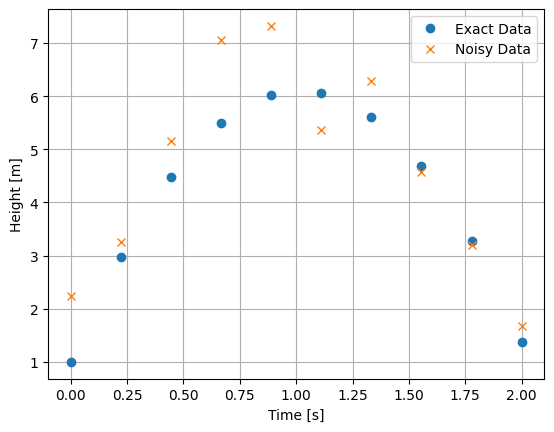

In [140]:
# display data
plt.plot(t_data, h_data_exact, 'o', label='Exact Data')
plt.plot(t_data, h_data_noisy, 'x', label='Noisy Data')
plt.xlabel("Time [s]")
plt.ylabel("Height [m]")
plt.legend()
plt.grid()
plt.show()

In [141]:
# define feed-forward neural network
class PINN(nn.Module):
    def __init__(self, n_hidden=20):
        super(PINN, self).__init__()
        # a simple MLP with two hidden layers
        self.net = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1)
        )
        
    def forward(self, t):
        "Forward pass: input shape (batch_size, 1) -> output shape (batch_size, 1)"
        return self.net(t)
    
# instatiate the model
model = PINN(n_hidden=20)

In [142]:
# automatic differentiation
def derivative(y, x):
    "Computes dy/dx"
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
        )[0]

In [143]:
def physics_loss(model, t):
    "Compute d(h_pred)/dt with known expression"
    
    t.requires_grad = True
    h_pred = model(t)
    dh_dt_pred = derivative(h_pred, t)
    
    # for each t, physics says dh/dt = v0 - g*t
    dh_dt_true = v0 - g*t
    
    loss_ode = torch.mean((dh_dt_pred - (dh_dt_true))**2)
    return loss_ode


def inital_condition_loss(model):
    "Enforce h(0) = h0"
    
    # evaluate model at t=0
    t0 = torch.zeros(1, 1, dtype=torch.float32, requires_grad=True)
    h0_pred = model(t0)
    return (h0_pred - h0).pow(2).mean()


def data_loss(model, t_data, h_data):
    "MSE between predicted h(t_i) and noisy measurements h_data"
    h_pred = model(t_data)
    return torch.mean((h_pred - h_data)**2)

In [144]:
# training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# hyperparameters for weighting the loss terms
lambda_data = 1
lambda_ode =1
lambda_ic = 1

# for logging
num_epochs = 2000
print_every =200


In [145]:
# training loop
model.train()

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # compute losses
    loss_data = data_loss(model, t_data_tensor, h_data_tensor)
    loss_ode = physics_loss(model, t_data_tensor)
    loss_ic = inital_condition_loss(model)
    
    # total loss
    loss = (lambda_data * loss_data +
            lambda_ode * loss_ode +
            lambda_ic * loss_ic)
    
    # backpropagation
    loss.backward()
    optimizer.step()
    
    # logging
    if (epoch+1) % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Loss: {loss.item():.4e}, "
              f"Data Loss: {loss_data.item():.4e}, "
              f"ODE Loss: {loss_ode.item():.4e}, "
              f"IC Loss: {loss_ic.item():.4e}")

Epoch 200/2000, Loss: 1.6518e+01, Data Loss: 2.3701e+00, ODE Loss: 1.4137e+01, IC Loss: 1.1605e-02
Epoch 400/2000, Loss: 1.6318e+00, Data Loss: 6.4697e-01, ODE Loss: 9.6382e-01, IC Loss: 2.0971e-02
Epoch 600/2000, Loss: 7.6273e-01, Data Loss: 5.2744e-01, ODE Loss: 2.1910e-01, IC Loss: 1.6201e-02
Epoch 800/2000, Loss: 5.7833e-01, Data Loss: 4.8918e-01, ODE Loss: 7.5478e-02, IC Loss: 1.3672e-02
Epoch 1000/2000, Loss: 5.2688e-01, Data Loss: 4.7165e-01, ODE Loss: 4.2175e-02, IC Loss: 1.3054e-02
Epoch 1200/2000, Loss: 5.1498e-01, Data Loss: 4.5611e-01, ODE Loss: 4.6059e-02, IC Loss: 1.2803e-02
Epoch 1400/2000, Loss: 5.0441e-01, Data Loss: 4.6366e-01, ODE Loss: 2.8195e-02, IC Loss: 1.2559e-02
Epoch 1600/2000, Loss: 5.0231e-01, Data Loss: 4.6190e-01, ODE Loss: 2.7941e-02, IC Loss: 1.2468e-02
Epoch 1800/2000, Loss: 4.9993e-01, Data Loss: 4.5991e-01, ODE Loss: 2.7591e-02, IC Loss: 1.2423e-02
Epoch 2000/2000, Loss: 4.9404e-01, Data Loss: 4.5552e-01, ODE Loss: 2.6112e-02, IC Loss: 1.2407e-02


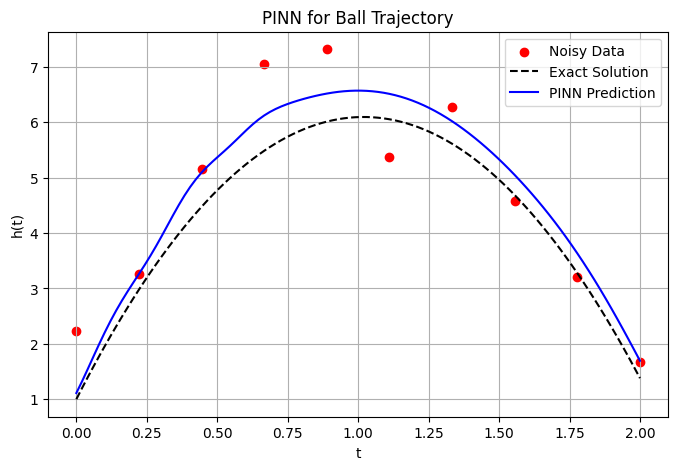

In [146]:
# evaluate the model
model.eval()
t_plot = np.linspace(t_min, t_max, 100).reshape(-1, 1).astype(np.float32)
t_plot_tensor = torch.tensor(t_plot, requires_grad=True)
h_pred_plot = model(t_plot_tensor).detach().numpy()

# True solution (for comparison)
h_true_plot = true_solution(t_plot)

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(t_data, h_data_noisy, color='red', label='Noisy Data')
plt.plot(t_plot, h_true_plot, 'k--', label='Exact Solution')
plt.plot(t_plot, h_pred_plot, 'b', label='PINN Prediction')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title('PINN for Ball Trajectory')
plt.grid(True)
plt.show()